In [ ]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
import math

In [1]:
def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ECG = signals[:,0]
        return ECG, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def signal_duration(data, samp_rate):
    return len(data) / samp_rate


def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline


def find_Rpeaks(ecg_flatten_signal, samp_rate):
    """Finds R peaks in ECG signal with dynamically changing window size.
    Returns a list of peaks and corresponding times."""
    margin = int(samp_rate/3)
    max_window_size = int(samp_rate)

    r_peaks = []
    current_position = 0
    signal_avg = (np.max(ecg_flatten_signal) + np.min(ecg_flatten_signal))*3 / 4

    while current_position < len(ecg_flatten_signal):
        window_size = min(max_window_size, len(ecg_flatten_signal) - current_position - 1)
        window_signal = ecg_flatten_signal[current_position: current_position + window_size]

        if not window_signal.any():
            current_position += margin
            continue

        max_value = window_signal[0]
        max_position_in_window = 0
        max_position_in_window = np.argmax(window_signal)

        max_position_in_signal = current_position + max_position_in_window
        if ecg_flatten_signal[max_position_in_signal] > signal_avg:
            r_peaks.append(max_position_in_signal)

        current_position = max_position_in_signal + margin

    return r_peaks
    

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Counts number of Rpeaks in every 15 seconds"""
    signal_duration = len(signal) / samp_rate  # Doba trvání signálu v sekundách
    window_duration = 15.0  # Délka okna v sekundách
    window_count = int(signal_duration / window_duration)  # Počet oken

    r_peak_counts = [0] * window_count  # Inicializace seznamu počtu R píků v jednotlivých oknech

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))  # Určení indexu okna, do kterého patří R pík
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1  # Zvýšení počtu R píků v příslušném okně

    return r_peak_counts


def plot_bpm_over_time(bpm_values, samp_rate, driver, window_duration=10.0):
    """BPM plot"""
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    

    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v závislosti na čase pro měření ' + driver)
    plt.xlabel('Čas (minuty)')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

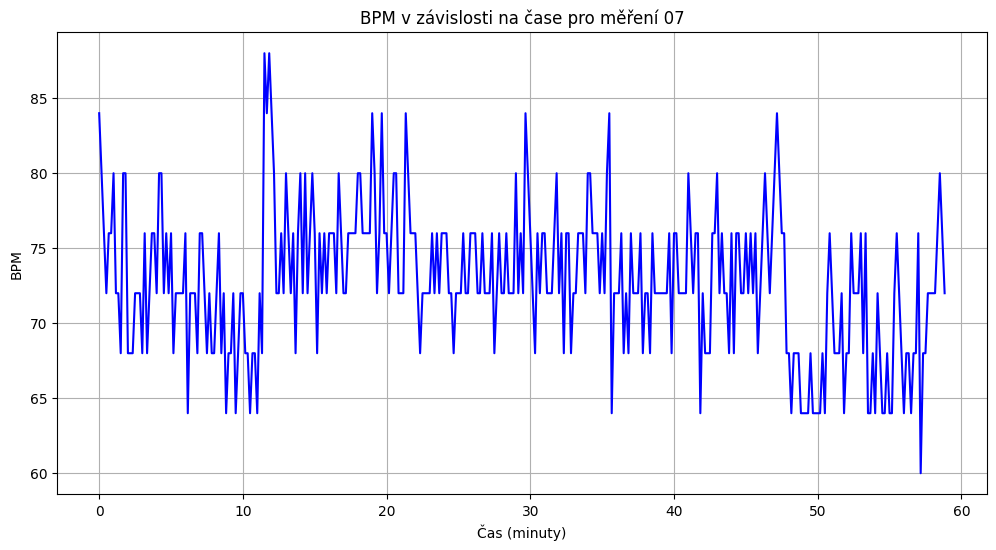

In [5]:
database = 'Database/drive07'
driver = database[-2:]
ECGnative, fields = load_data(database)
samp_rate = fields['fs']
seconds = signal_duration(ECGnative, samp_rate)

ecg_data = np.array(ECGnative)
cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)
Rpeaks = find_Rpeaks(ecg_edit_fft, samp_rate)
r_peak_counts = [count* 4 for count in count_rpeaks_in_windows(ecg_edit_fft, Rpeaks, samp_rate)]

plot_bpm_over_time(r_peak_counts, samp_rate, driver)